In [21]:
#### Import de libraries
import seaborn as sns
import math
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import importlib
import functions
from tqdm import tqdm 

In [22]:
warnings.filterwarnings("ignore")

In [23]:
X_train_reg = pd.read_csv('X_train_final.csv')
X_test_reg = pd.read_csv('X_test_final.csv')
X_oot_reg = pd.read_csv('X_oot_final.csv')

In [24]:
selected_vars=X_train_reg.columns.to_list()
selected_vars

['CRTOC_IND_0015_dis',
 'CRTOC_IND_0164_dis',
 'CRTOC_AG_NBJCRE_2T_IND_0009_dis',
 'ratio_cred_ma_dis',
 'CRTOC_AG_MVTAFF_2T_IND_0010_dis',
 'CRTOC_MOY_MVTAFF_IND_0010_dis',
 'CODETAJUR_I_dis',
 'SECTNAF',
 'DDefaut_NDB',
 'datdelhis',
 'CODNAF2']

In [25]:
cible="DDefaut_NDB"
date="datdelhis"
codnaf = "CODNAF2"

In [26]:
selected_vars.remove(cible)
selected_vars.remove(date)
selected_vars.remove(codnaf)

In [27]:
# Les variables selectionnées sont pas ordre de relation avec la variable cible
selected_vars 

['CRTOC_IND_0015_dis',
 'CRTOC_IND_0164_dis',
 'CRTOC_AG_NBJCRE_2T_IND_0009_dis',
 'ratio_cred_ma_dis',
 'CRTOC_AG_MVTAFF_2T_IND_0010_dis',
 'CRTOC_MOY_MVTAFF_IND_0010_dis',
 'CODETAJUR_I_dis',
 'SECTNAF']

Avant de construire le modèle, il faut s’assurer que les modalités des variables sont stables et robustes, il faut vérifier certains critères. Ces critères sont les suivants : 
- Les modalités doivent être stables en taux du critère à modéliser (pas de croisement entre les modalités au cours du temps) et en volumétrie ;
- Un effectif minimum de 5% de la population doit être trouvé dans chaque modalité (à l’exception, de variable particulièrement explicative du critère à modéliser et
particulièrement fiable, pour exemple, dans le cadre de score de risque, pour des variables de dépassement d’autorisation ou d’impayé un effectif moindre est toléré) ;
- Les modalités doivent être séparée d’au moins 30% relatif en termes de taux de variable cible.

De fait, les analyses ci-dessous sont réalisées pour vérifier ces critères. On va utiliser également le PSI (Population Stability Index) pour vérifier la stabilité des modalités.

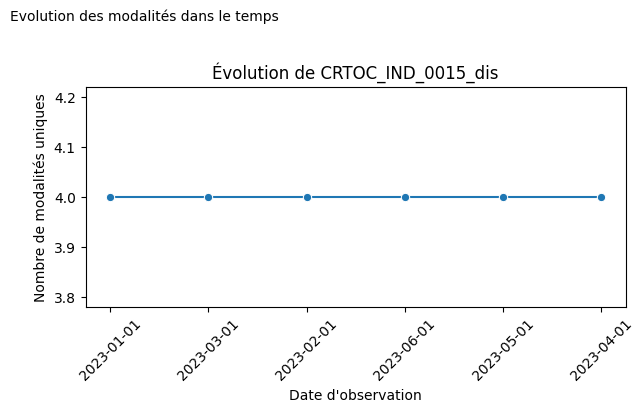

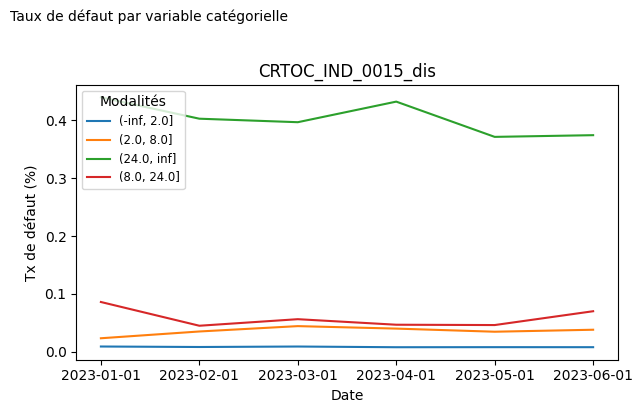

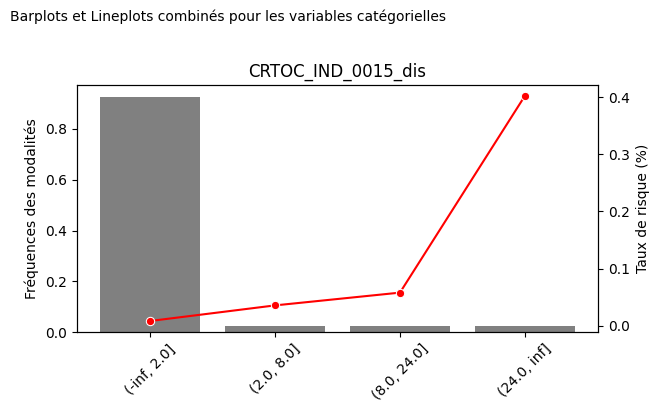

Les variables suivantes ont au moins une modalité avec une fréquence <= 5.0% :
['CRTOC_IND_0015_dis']
  CRTOC_IND_0015_dis  taux_cible  ecart_relatif
0        (-inf, 2.0]    0.008414       0.000000
1         (2.0, 8.0]    0.035670     323.928115
2        (8.0, 24.0]    0.057983      62.551921
3        (24.0, inf]    0.401790     592.945444


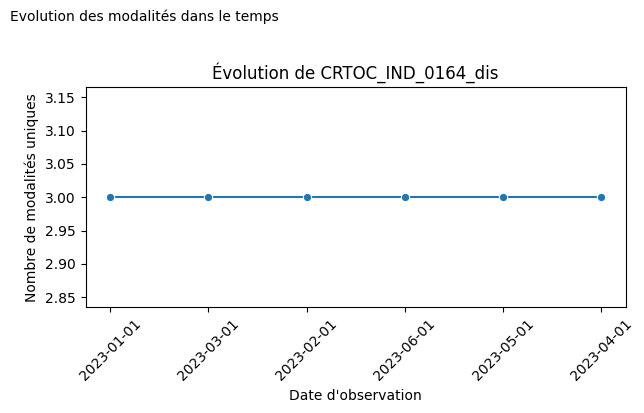

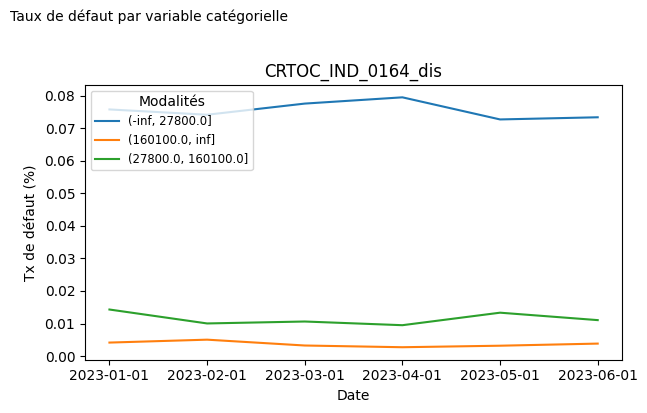

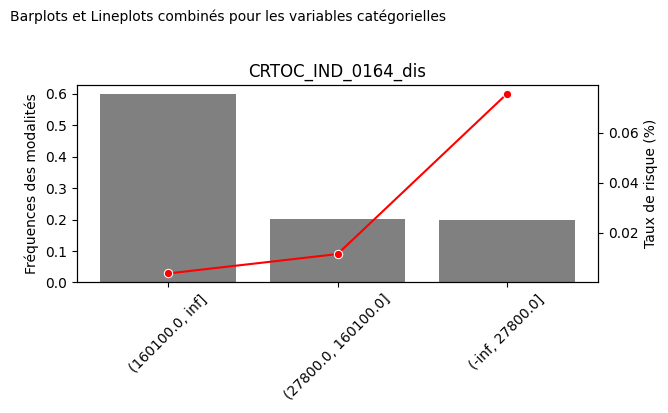

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
    CRTOC_IND_0164_dis  taux_cible  ecart_relatif
0      (160100.0, inf]    0.003690       0.000000
1  (27800.0, 160100.0]    0.011453     210.425121
2      (-inf, 27800.0]    0.075508     559.269532


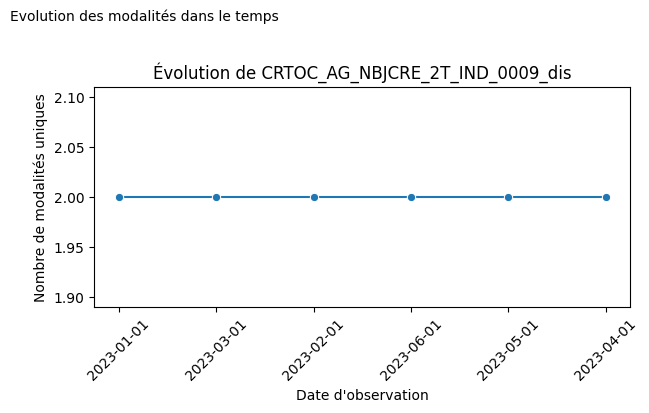

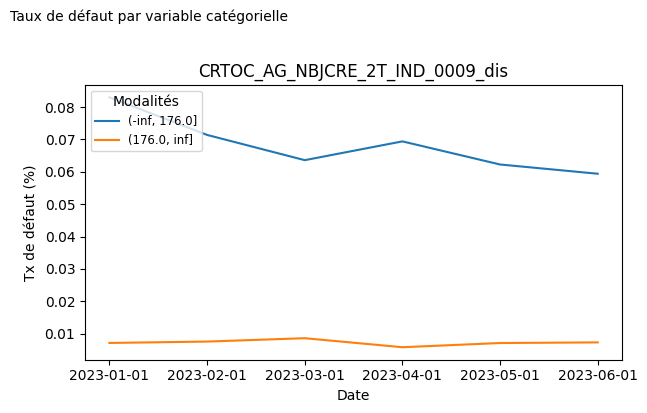

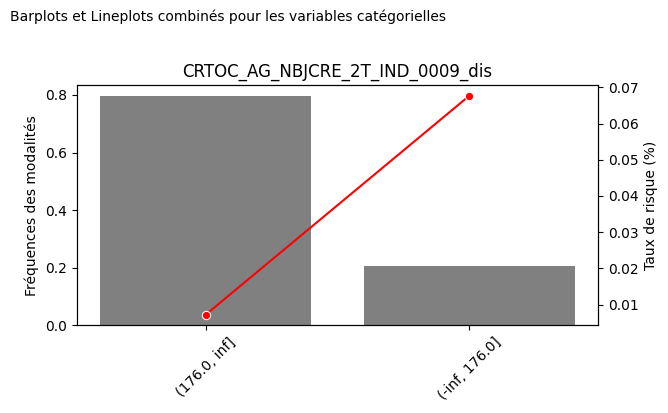

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_NBJCRE_2T_IND_0009_dis  taux_cible  ecart_relatif
0                    (176.0, inf]    0.007258       0.000000
1                   (-inf, 176.0]    0.067669     832.374357


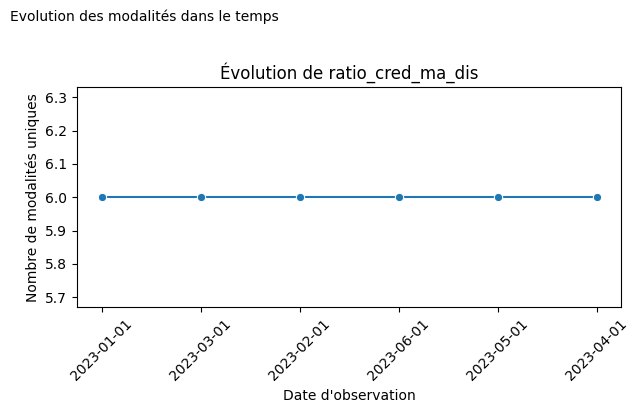

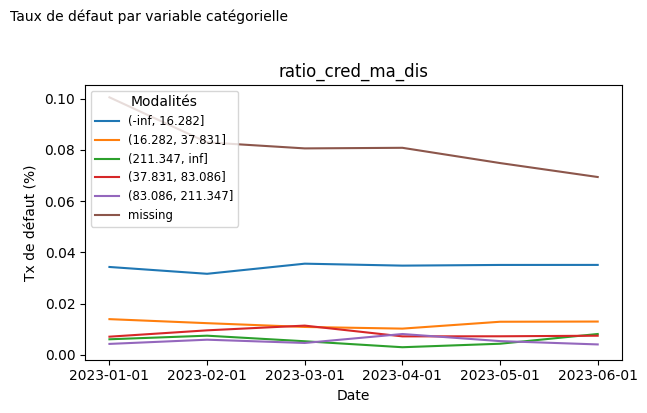

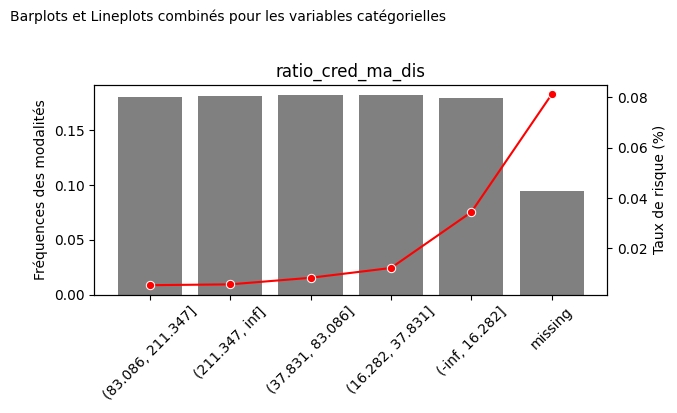

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
   ratio_cred_ma_dis  taux_cible  ecart_relatif
0  (83.086, 211.347]    0.005417       0.000000
1     (211.347, inf]    0.005745       6.055271
2   (37.831, 83.086]    0.008355      45.441911
3   (16.282, 37.831]    0.012246      46.568482
4     (-inf, 16.282]    0.034425     181.097640
5            missing    0.081208     135.901226


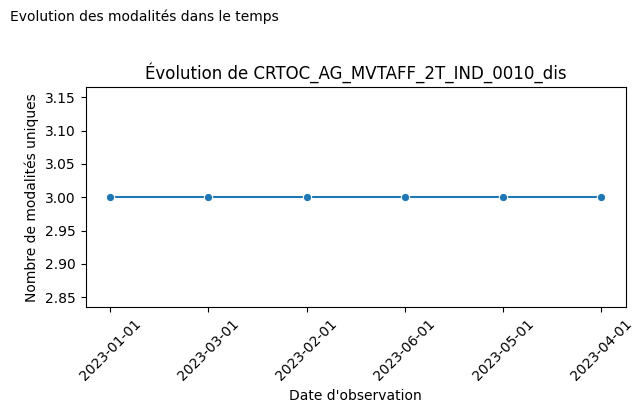

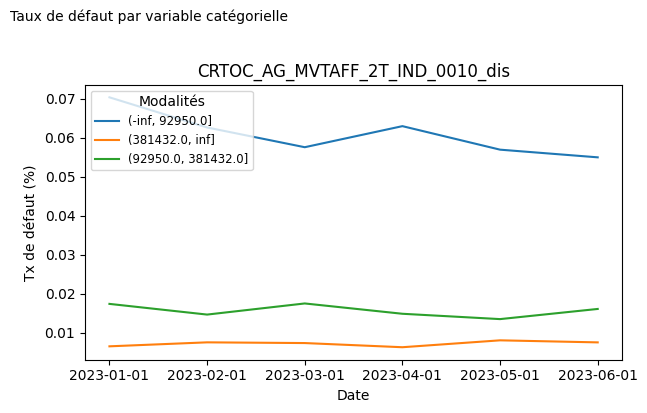

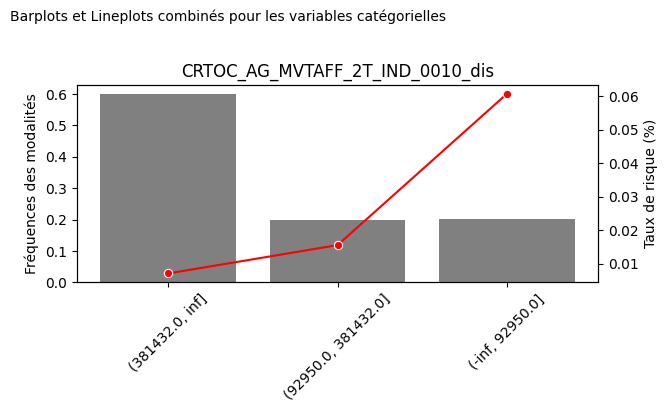

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_MVTAFF_2T_IND_0010_dis  taux_cible  ecart_relatif
0                 (381432.0, inf]    0.007154       0.000000
1             (92950.0, 381432.0]    0.015609     118.201405
2                 (-inf, 92950.0]    0.060721     289.011530


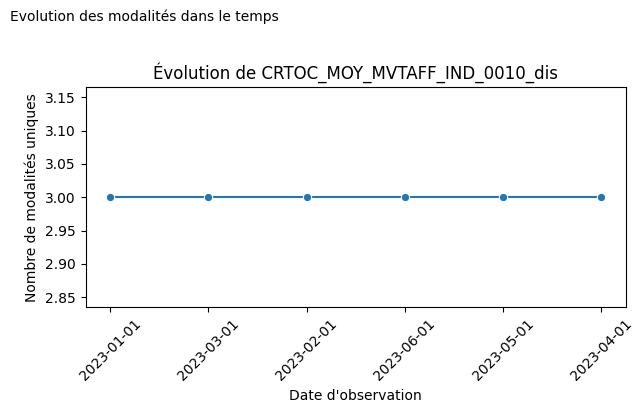

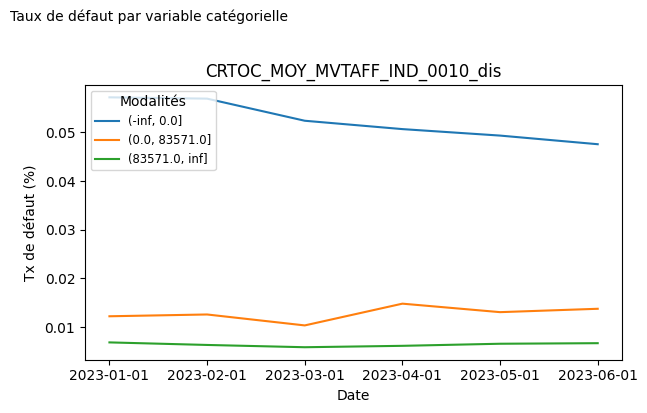

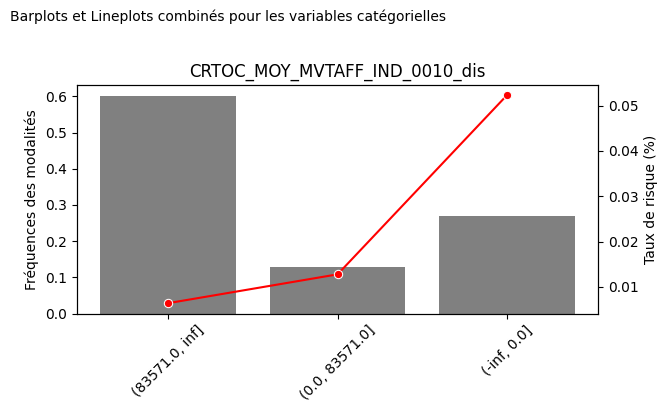

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_MOY_MVTAFF_IND_0010_dis  taux_cible  ecart_relatif
0                (83571.0, inf]    0.006422       0.000000
1                (0.0, 83571.0]    0.012776      98.955737
2                   (-inf, 0.0]    0.052278     309.186882


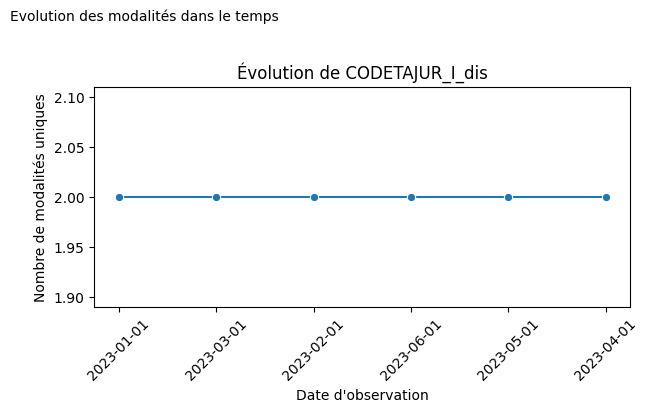

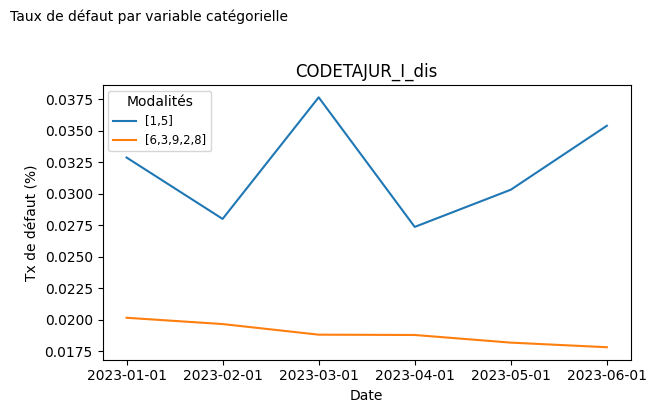

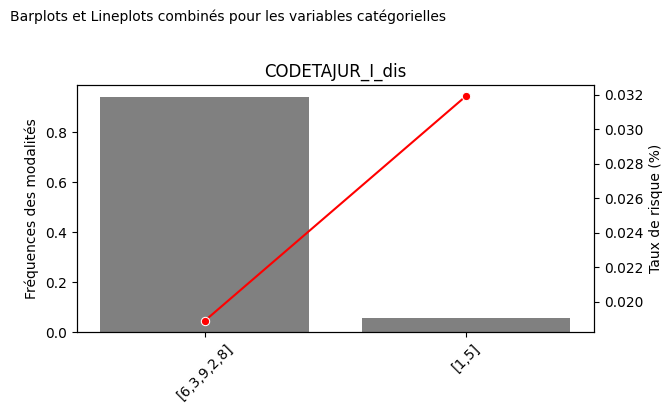

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CODETAJUR_I_dis  taux_cible  ecart_relatif
0     [6,3,9,2,8]    0.018884       0.000000
1           [1,5]    0.031932      69.096032


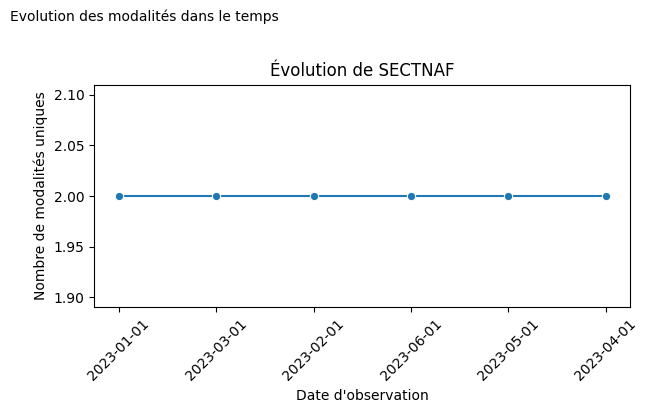

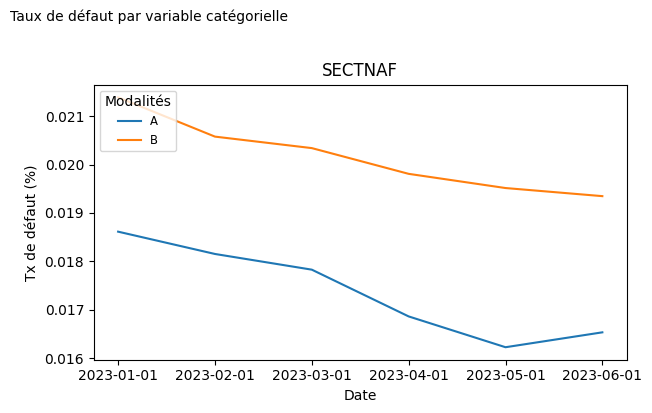

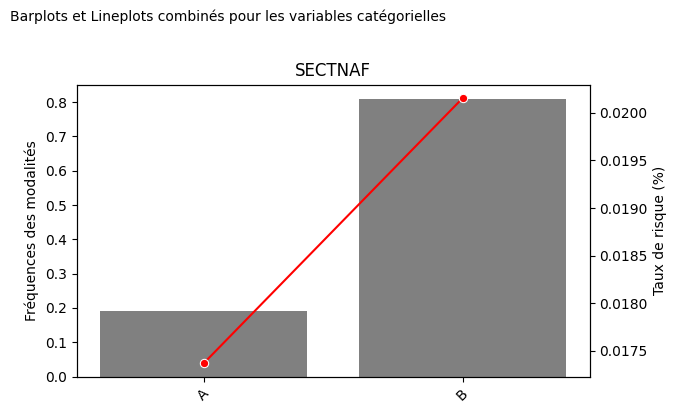

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  SECTNAF  taux_cible  ecart_relatif
0       A    0.017368       0.000000
1       B    0.020156      16.052537


In [28]:
importlib.reload(functions)

for col in selected_vars :
    functions.plot_modalities_over_time(X_test_reg, date, [col])
    print("="*15)
    functions.tx_rsq_par_var(X_test_reg,[col],date,cible)
    print("="*15)
    functions.combined_barplot_lineplot(X_test_reg, [col], cible)
    print("="*15)
    functions.test_freq_by_group(X_test_reg, [col])
    print("="*15)
    print(functions.calculate_relative_difference(X_test_reg, col, cible))


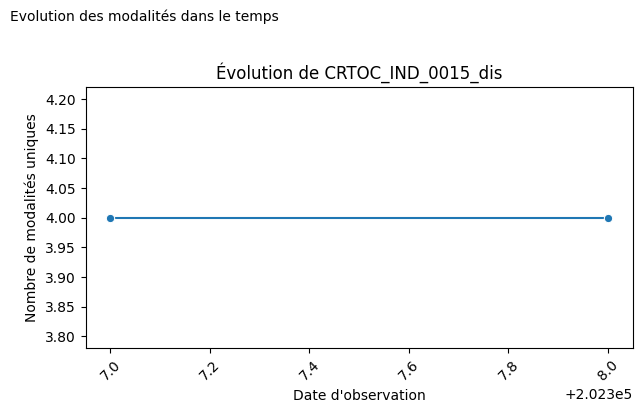

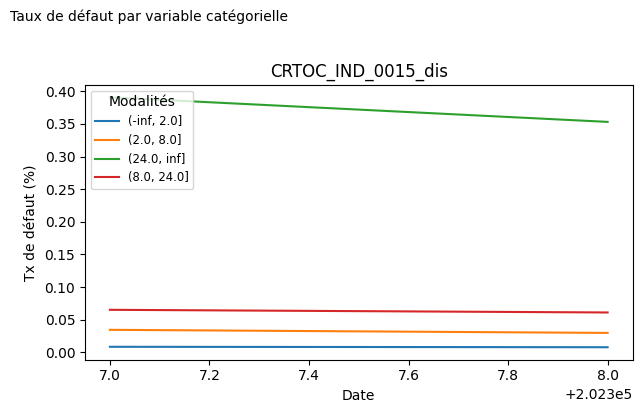

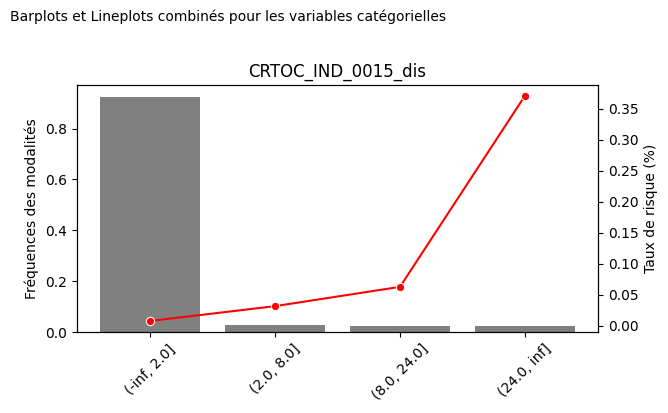

Les variables suivantes ont au moins une modalité avec une fréquence <= 5.0% :
['CRTOC_IND_0015_dis']
  CRTOC_IND_0015_dis  taux_cible  ecart_relatif
0        (-inf, 2.0]    0.008017       0.000000
1         (2.0, 8.0]    0.031915     298.069029
2        (8.0, 24.0]    0.062935      97.197347
3        (24.0, inf]    0.370215     488.246549


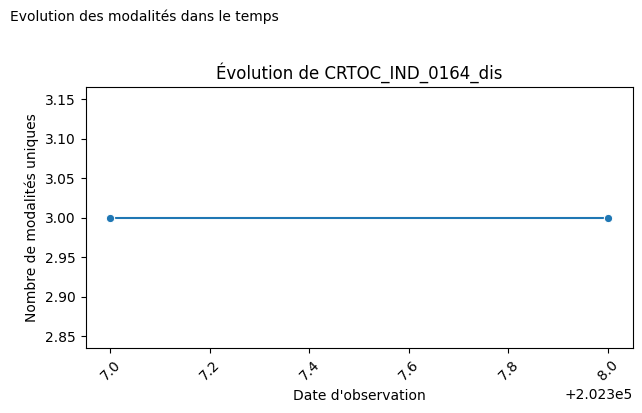

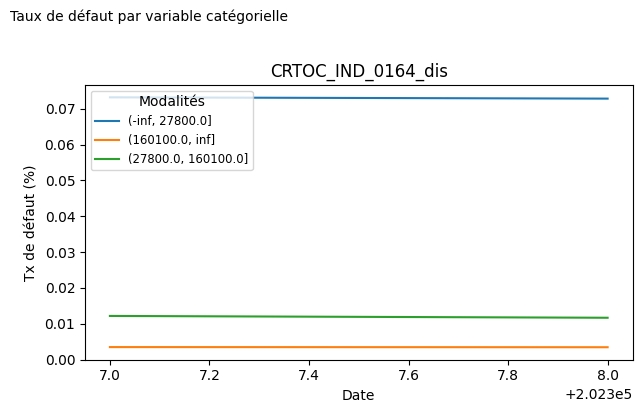

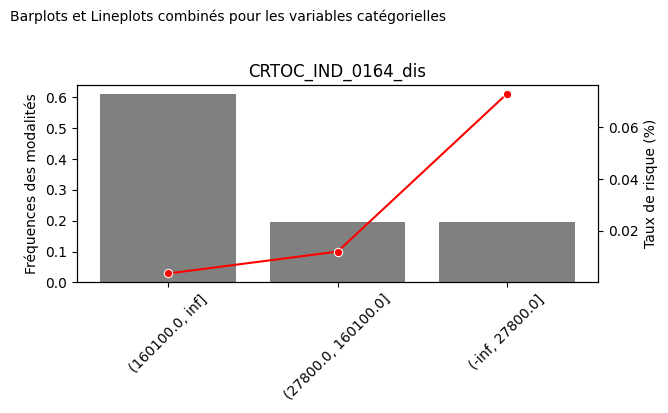

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
    CRTOC_IND_0164_dis  taux_cible  ecart_relatif
0      (160100.0, inf]    0.003500       0.000000
1  (27800.0, 160100.0]    0.011951     241.444495
2      (-inf, 27800.0]    0.072971     510.562076


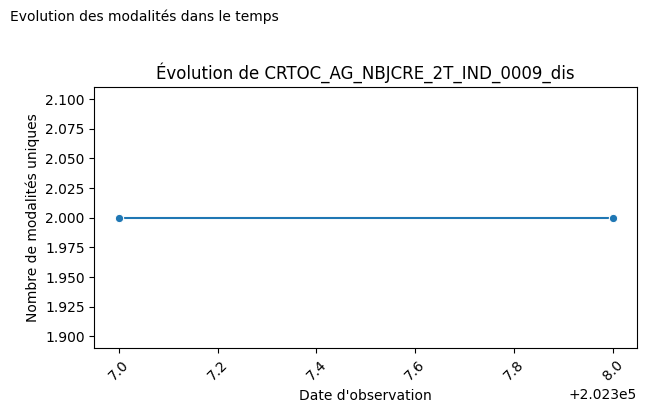

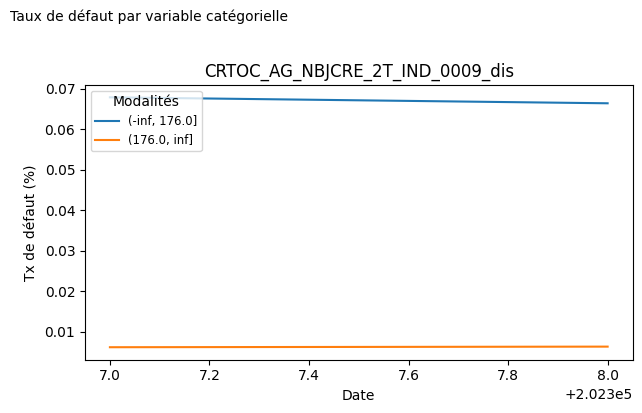

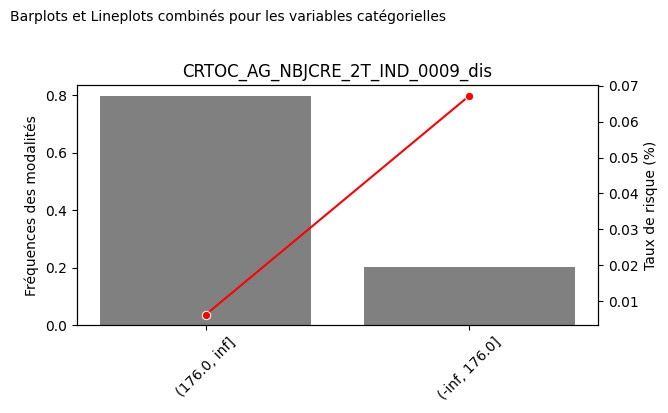

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_NBJCRE_2T_IND_0009_dis  taux_cible  ecart_relatif
0                    (176.0, inf]    0.006315       0.000000
1                   (-inf, 176.0]    0.067178     963.861482


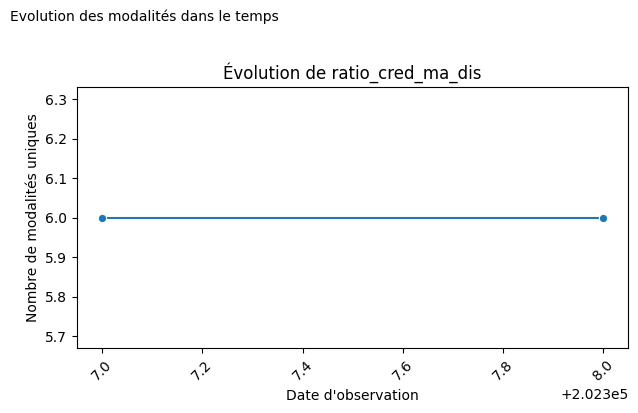

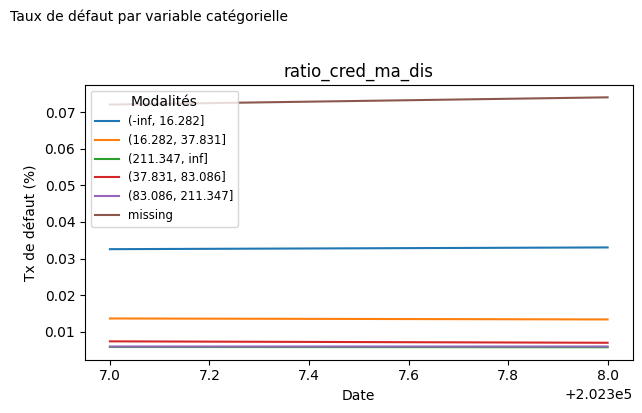

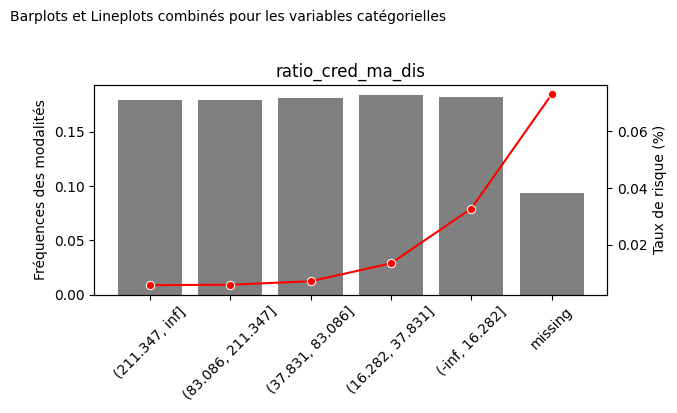

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
   ratio_cred_ma_dis  taux_cible  ecart_relatif
0     (211.347, inf]    0.005819       0.000000
1  (83.086, 211.347]    0.005985       2.850303
2   (37.831, 83.086]    0.007198      20.271003
3   (16.282, 37.831]    0.013508      87.653883
4     (-inf, 16.282]    0.032806     142.868210
5            missing    0.073038     122.635824


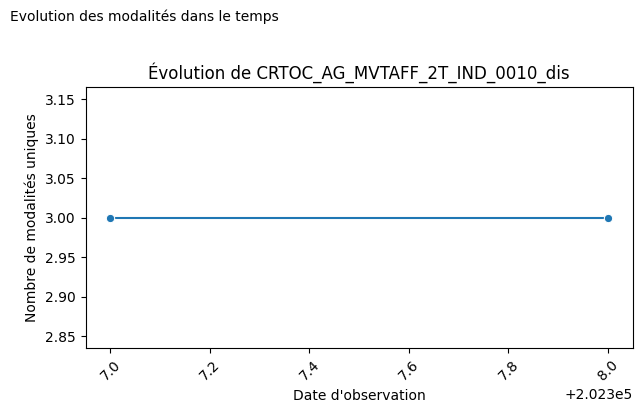

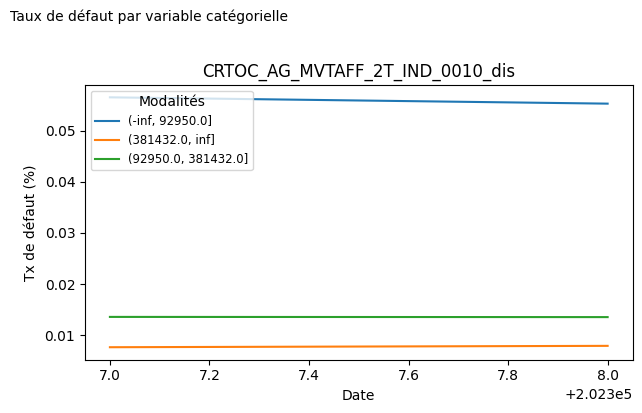

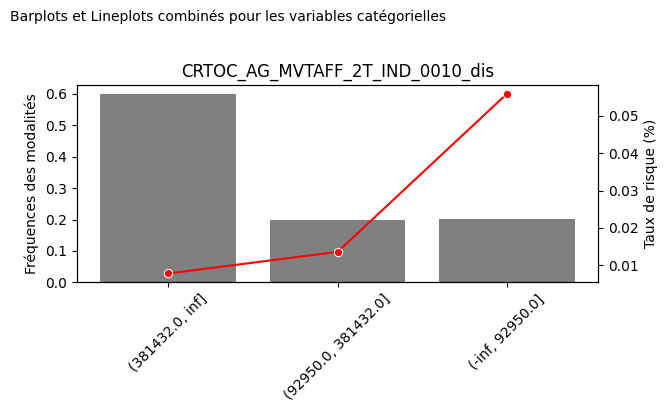

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_AG_MVTAFF_2T_IND_0010_dis  taux_cible  ecart_relatif
0                 (381432.0, inf]    0.007809       0.000000
1             (92950.0, 381432.0]    0.013580      73.901406
2                 (-inf, 92950.0]    0.055882     311.517361


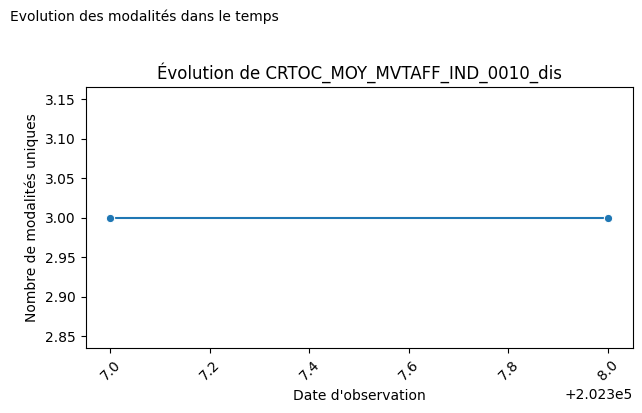

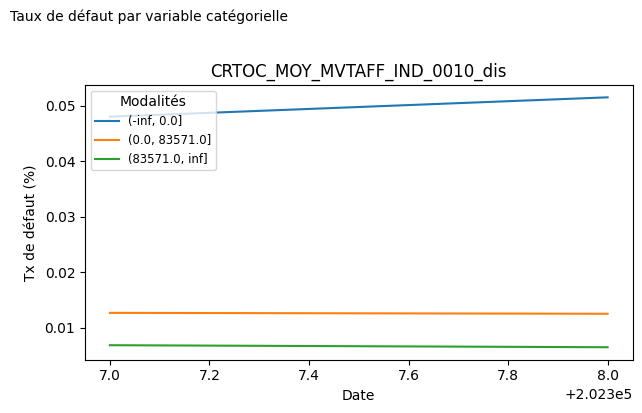

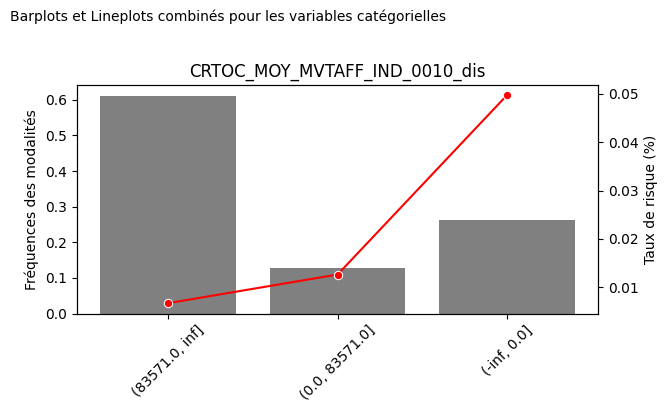

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CRTOC_MOY_MVTAFF_IND_0010_dis  taux_cible  ecart_relatif
0                (83571.0, inf]    0.006710       0.000000
1                (0.0, 83571.0]    0.012637      88.314341
2                   (-inf, 0.0]    0.049731     293.538980


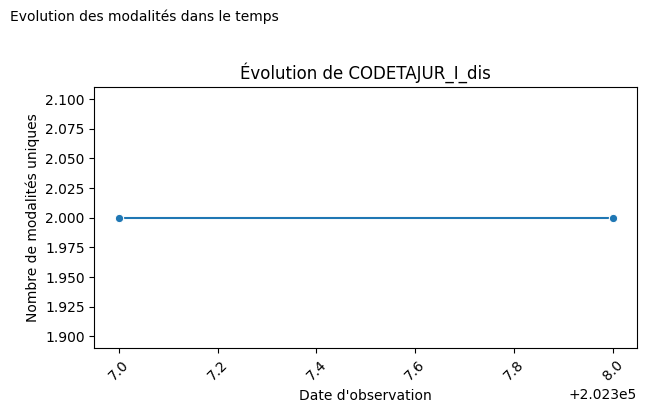

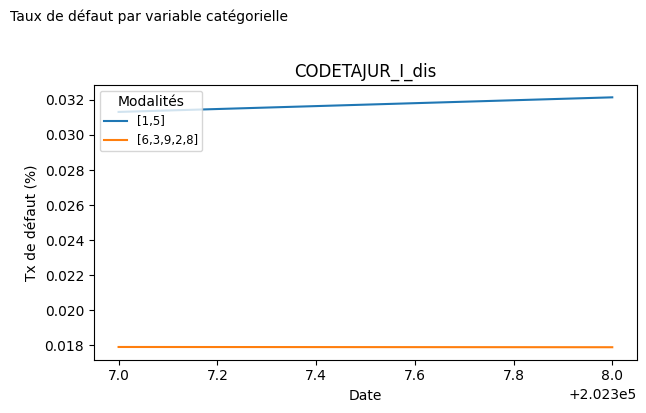

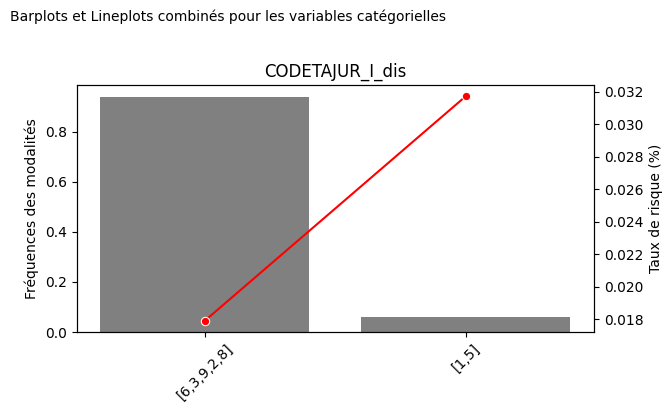

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  CODETAJUR_I_dis  taux_cible  ecart_relatif
0     [6,3,9,2,8]    0.017898       0.000000
1           [1,5]    0.031732      77.293289


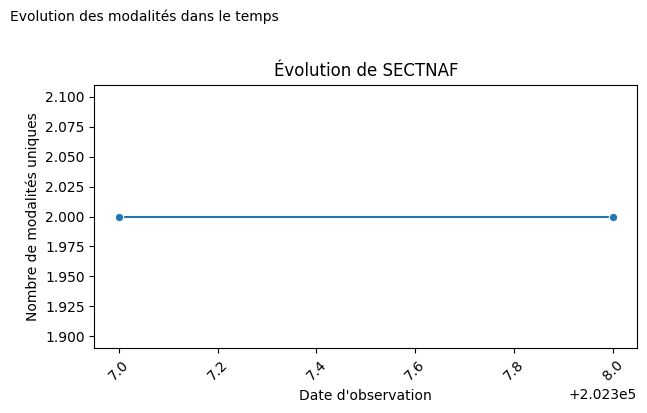

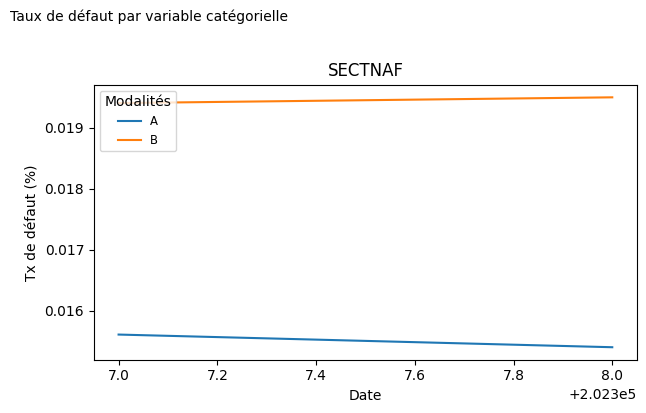

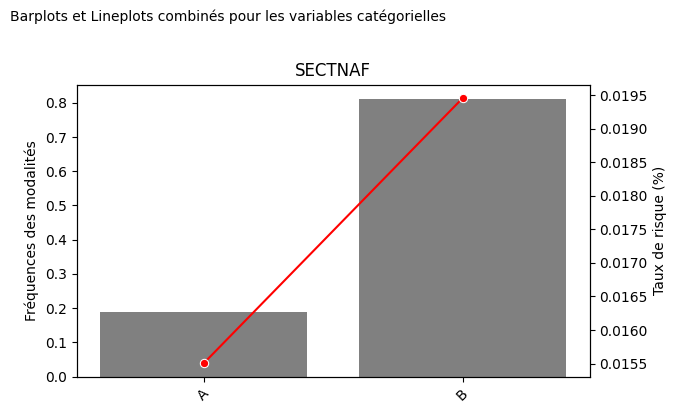

Aucune variable n'a de modalités avec moins de 5% d'effectifs.
  SECTNAF  taux_cible  ecart_relatif
0       A    0.015504       0.000000
1       B    0.019455      25.482733


In [29]:
importlib.reload(functions)

for col in selected_vars :
    functions.plot_modalities_over_time(X_oot_reg, date, [col])
    print("="*15)
    functions.tx_rsq_par_var(X_oot_reg,[col],date,cible)
    print("="*15)
    functions.combined_barplot_lineplot(X_oot_reg, [col], cible)
    print("="*15)
    functions.test_freq_by_group(X_oot_reg, [col])
    print("="*15)
    print(functions.calculate_relative_difference(X_oot_reg, col, cible))


# I. Construction du modèle
## I.1 Démarche estimation du meilleur modèle logistique (1)

On vérifie pour chaque variable (et donc notamment à chaque fois qu’une variable est ajoutée dans les modèles itératifs, mais aussi au global dans les modèles
automatiques) que :
- Les coefficients de chaque modalité sont significatifs (5% en général, 10% accepté si nécessaire) ;
- La significativité globale des coefficients est ok (5%) ;
- Les coefficients sont croissants avec le risque de la modalité (par construction, la modalité 2 et moins risquée que la 3. Le coef de la modalité 3 doit donc etre
plus grand que celui de la 2) ;
- Les odds ratios sont significatifs entre chaque modalités d’une même variables (positifs et que leur IC ne contiennent pas 1).

In [ ]:
y_train = X_train_reg[cible].values.flatten()  # Convert to 1D numpy array
y_test = X_test_reg[cible].values.flatten()  
y_oot = X_oot_reg[cible].values.flatten()  

In [36]:
importlib.reload(functions)

cat_vars = []  # To store the selected variables
results= []
model_summaries = {}  # To store model summaries for each iteration
for i, col in tqdm(enumerate(selected_vars)):
    cat_vars.append(col)
    gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, \
    flag_VIF, flag_OR,model_train, modalites_reference = functions.logit_reg(cat_vars, cible, y_train,X_train_reg,y_test, X_test_reg,y_oot, X_oot_reg)
    # Stocker les résultats
    results.append({
        "Nb de variables": i+1,
        "Variables": cat_vars.copy(),
        "Gini_train": gini_index_train,
        "Gini_test": gini_index_test,
        "Gini_oot": gini_index_oot,
        "AUC-PR_train": auc_pr_train,
        "AUC-PR_test": auc_pr_test,
        "AUC-PR_oot": auc_pr_oot,
        "flag_VIF": flag_VIF,
        "flag_significativite": flag_significativite,
        "flag_OR": flag_OR,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

8it [00:57,  7.24s/it]


In [37]:
# Affichage des résumés de modèles
for model_name, summary in model_summaries.items():
    print(f"Summary for {model_name}:\n", summary)

Summary for Model_1:
                            Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396407
Method:                           MLE   Df Model:                            3
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                  0.2772
Time:                        23:00:00   Log-Likelihood:                -27674.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -4.7945      0.018   -262.046      0.000      -4.830      -4.759
CRTOC_IND_0015_dis_(2.0, 8.0]      1.4059      0.

In [38]:
results_df= pd.DataFrame(results)
results_df

,Nb de variables,Variables,Gini_train,Gini_test,Gini_oot,AUC-PR_train,AUC-PR_test,AUC-PR_oot,flag_VIF,flag_significativite,flag_OR
0,1,[CRTOC_IND_0015_dis],0.572379,0.562420,0.561532,0.412177,0.407514,0.393115,1,1,1
1,2,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis]",0.738689,0.734459,0.731884,0.413242,0.407161,0.392656,1,1,1
2,3,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.752797,0.748056,0.749294,0.409672,0.402049,0.390661,1,1,1
3,4,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.764296,0.764549,0.760341,0.387150,0.383549,0.360727,1,0,0
4,5,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.773817,0.776683,0.772534,0.397237,0.392856,0.369858,1,0,0
5,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.787499,0.790861,0.786295,0.329914,0.339082,0.313316,1,0,0
6,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.789753,0.793879,0.789536,0.329883,0.331372,0.307483,1,0,0
7,8,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.789936,0.794455,0.789639,0.328159,0.330694,0.307004,1,0,0


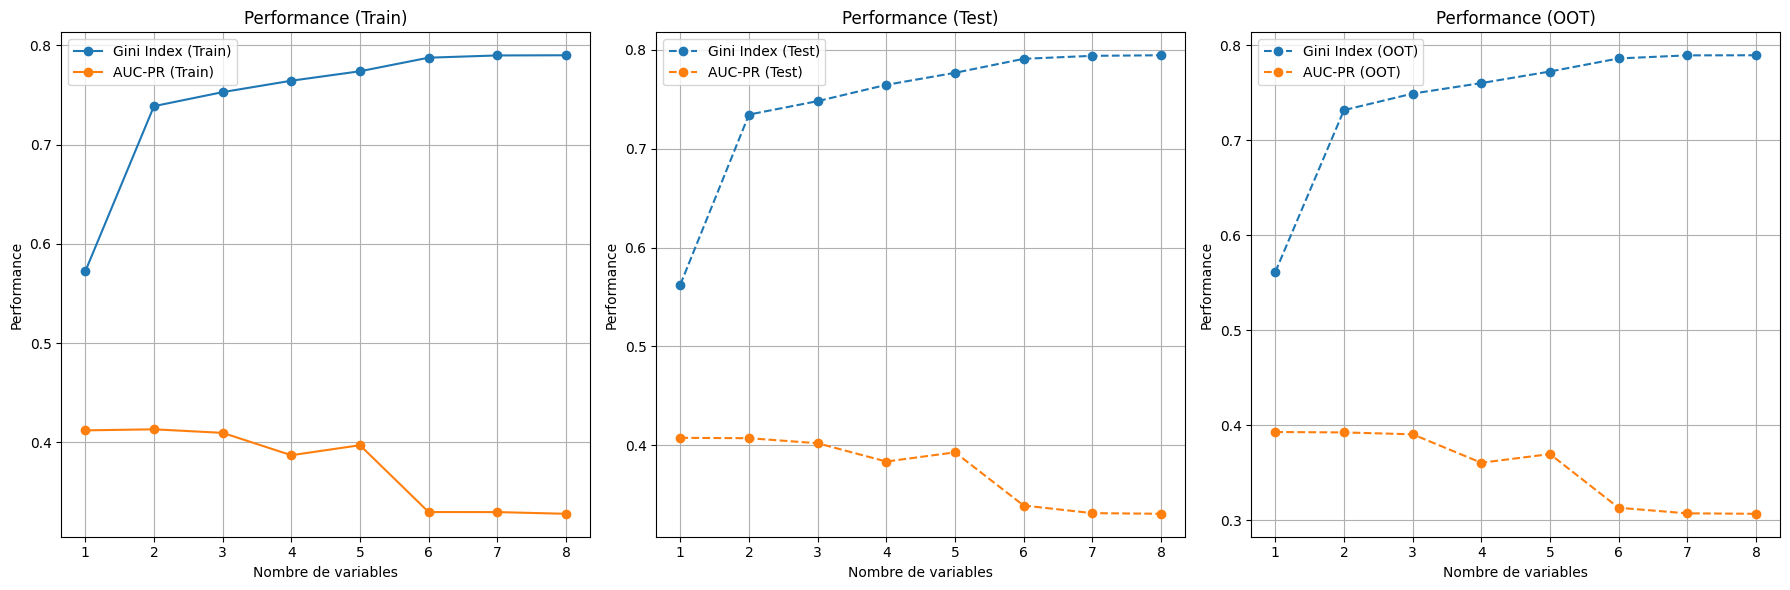

In [43]:
import matplotlib.pyplot as plt

# Création de la figure avec une disposition optimisée
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

# Performance sur les données d'entraînement
axes[0].plot(results_df["Nb de variables"], results_df["Gini_train"], label="Gini Index (Train)", marker='o')
axes[0].plot(results_df["Nb de variables"], results_df["AUC-PR_train"], label="AUC-PR (Train)", marker='o')
axes[0].set_title("Performance (Train)")
axes[0].set_xlabel("Nombre de variables")
axes[0].set_ylabel("Performance")
axes[0].legend()
axes[0].grid()

# Performance sur les données de test
axes[1].plot(results_df["Nb de variables"], results_df["Gini_test"], label="Gini Index (Test)", marker='o', linestyle='--')
axes[1].plot(results_df["Nb de variables"], results_df["AUC-PR_test"], label="AUC-PR (Test)", marker='o', linestyle='--')
axes[1].set_title("Performance (Test)")
axes[1].set_xlabel("Nombre de variables")
axes[1].set_ylabel("Performance")
axes[1].legend()
axes[1].grid()

# Performance sur les données hors échantillon (OOT)
axes[2].plot(results_df["Nb de variables"], results_df["Gini_oot"], label="Gini Index (OOT)", marker='o', linestyle='--')
axes[2].plot(results_df["Nb de variables"], results_df["AUC-PR_oot"], label="AUC-PR (OOT)", marker='o', linestyle='--')
axes[2].set_title("Performance (OOT)")
axes[2].set_xlabel("Nombre de variables")
axes[2].set_ylabel("Performance")
axes[2].legend()
axes[2].grid()

# Ajustement des espacements entre les sous-graphiques
fig.tight_layout()
plt.show()


Selon le graphique ci-dessus et le tableau résumant les performances des modèles, le meilleur modèle à choisir est le modèle à trois variables.
En effet, il nous permet d'avoir le meilleur AUC-PR et un indice de gini de plus de 70%. De plus, tous ses coefficients sont significatifs et il n'y a pas de problème de multicolinéarité (VIF < 10). 

Par ailleurs, il ne semble pas avoir de surapprentissage car les performances sur le jeu de test et out of time sont similaires à celles sur le jeu d'entraînement.

In [44]:
# Extraire les modèles du meilleur modèle
vars_selected1 = results_df["Variables"].iloc[2]
vars_selected1

['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis', 'CRTOC_AG_NBJCRE_2T_IND_0009_dis']

In [47]:
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_test, auc_pr_test, flag_significativite, flag_VIF, flag_OR, model1, modalites_reference =functions.logit_reg(vars_selected1, cible, y_train, X_train_reg)

In [48]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396404
Method:                           MLE   Df Model:                            6
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                  0.3169
Time:                        23:05:39   Log-Likelihood:                -26154.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -5.7555      0.035   -165.091      0.000      -5.824      -5.687
CRTOC_IND_0015_dis_(2.0, 8.0]                     0.4082      0.062      6.586      0.000       0.287       0.530
CRTOC_IND_0015_dis_(24.0, inf]                    2.9003      0.036     80.538      0.000       2.830       2.971
CRTOC_IND_0015_dis_(8.0, 24.0]                    0.8500      0.051     16.742      0.000       0.750       0.950
CRTOC_IND_0164_dis_(-inf, 27800.0]                1.8708      0.043     43.815      0.000       1.787       1.954
CRTOC_IND_0164_dis_(27800.0, 160100.0]            0.9291      0.049     18.826      0.000       0.832       1.026
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]     0.6458      0.034     19.058      0.000       0.579       0.712
=================================================================================================================
"""

In [49]:
coefficients = pd.Series(model1.params)

for modalite in modalites_reference:
    if modalite not in coefficients.index:
        coefficients[modalite] = 0

coefficients

const                                           -5.755521
CRTOC_IND_0015_dis_(2.0, 8.0]                    0.408200
CRTOC_IND_0015_dis_(24.0, inf]                   2.900332
CRTOC_IND_0015_dis_(8.0, 24.0]                   0.849997
CRTOC_IND_0164_dis_(-inf, 27800.0]               1.870761
CRTOC_IND_0164_dis_(27800.0, 160100.0]           0.929130
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]    0.645754
CRTOC_IND_0015_dis_(-inf, 2.0]                   0.000000
CRTOC_IND_0164_dis_(160100.0, inf]               0.000000
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]     0.000000
dtype: float64

In [50]:
importlib.reload(functions)
SC_df = functions.compute_score(vars_selected1,coefficients,X_train_reg,cible)
SC_df

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
8,CRTOC_AG_NBJCRE_2T_IND_0009_dis,"(176.0, inf]","CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]",0.000000,0.645754,119.212140,0.064575,0.794534,0.007112,0.895440,2,3,94.718093,0.176697
7,CRTOC_AG_NBJCRE_2T_IND_0009_dis,"(-inf, 176.0]","CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]",0.645754,0.645754,0.000000,0.064575,0.205466,0.068018,0.000000,2,3,94.718093,0.176697
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.900332,535.428121,0.290033,0.925746,0.008208,0.979179,4,3,516.488489,0.316795
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.408200,2.900332,460.070628,0.290033,0.025105,0.032657,0.917155,4,3,516.488489,0.316795
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",0.849997,2.900332,378.510735,0.290033,0.024485,0.060684,0.846054,4,3,516.488489,0.316795
1,CRTOC_IND_0015_dis,"(24.0, inf]","CRTOC_IND_0015_dis_(24.0, inf]",2.900332,2.900332,0.000000,0.290033,0.024664,0.394190,0.000000,4,3,516.488489,0.316795
6,CRTOC_IND_0164_dis,"(160100.0, inf]","CRTOC_IND_0164_dis_(160100.0, inf]",0.000000,1.870761,345.359739,0.187076,0.599983,0.003612,0.952946,3,3,241.942111,0.506508
5,CRTOC_IND_0164_dis,"(27800.0, 160100.0]","CRTOC_IND_0164_dis_(27800.0, 160100.0]",0.929130,1.870761,173.833739,0.187076,0.199800,0.010467,0.863636,3,3,241.942111,0.506508
4,CRTOC_IND_0164_dis,"(-inf, 27800.0]","CRTOC_IND_0164_dis_(-inf, 27800.0]",1.870761,1.870761,0.000000,0.187076,0.200216,0.076756,0.000000,3,3,241.942111,0.506508


In [52]:
score = functions.calculate_individual_scores(SC_df, X_train_reg[vars_selected1+[cible]])

0it [00:00, ?it/s]

396411it [00:16, 24122.02it/s]


In [53]:
score["score"].groupby(score[cible]).describe()

,count,mean,std,min,25%,50%,75%,max
DDefaut_NDB,,,,,,,,
0,388631.0,863.298459,193.008180,0.0,828.474,1000.000000,1000.000000,1000.0
1,7780.0,346.141730,363.420043,0.0,0.000,378.510735,654.640261,1000.0


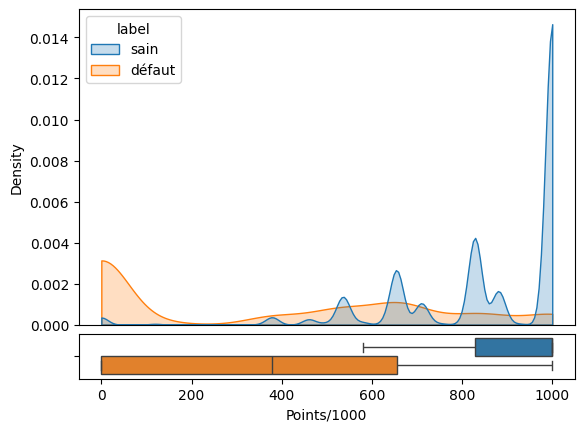

In [54]:
importlib.reload(functions)
functions.plot_kde_and_boxplot(score,cible)

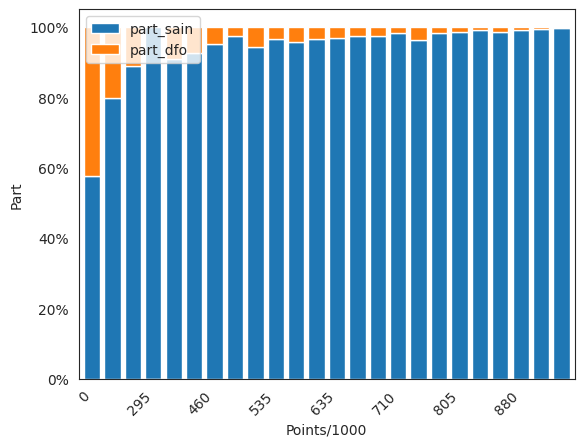

In [55]:
importlib.reload(functions)
functions.plot_bar_stacked(score,cible)

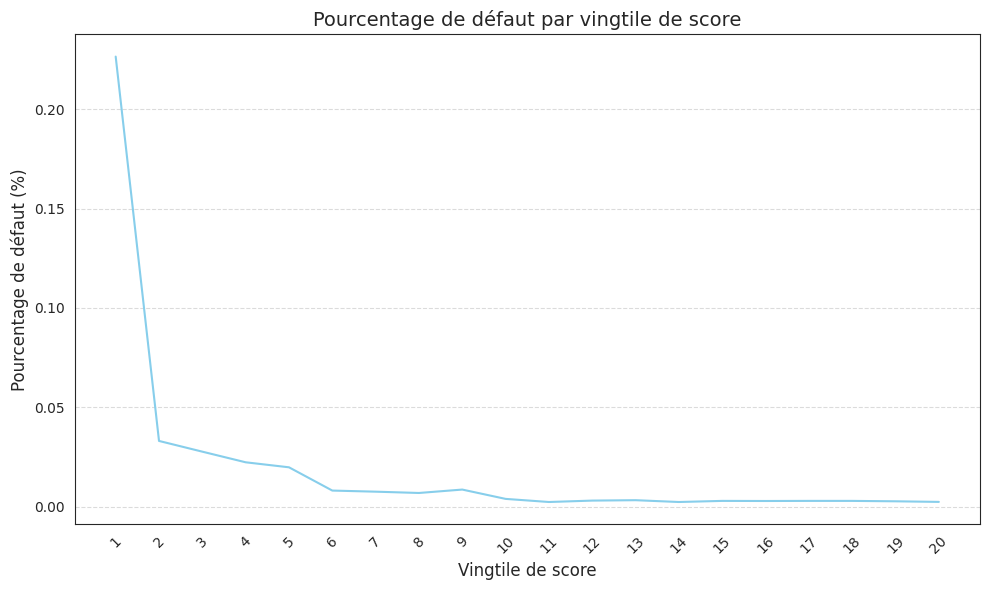

In [87]:
temp_df = score[["score",cible]].copy()

# Créer les vingtiles
# temp_df['ventile'] = pd.qcut(temp_df['score'], q=100, labels=False,duplicates='drop') +1
# temp_df['ventile'] = pd.cut(temp_df['score'], bins=20, labels=False) + 1

# Classer les scores pour leur attribuer des rangs uniques
temp_df['ranked_score'] = temp_df['score'].rank(method='first')

# Diviser les rangs en vingtiles
temp_df['ventile'] = pd.qcut(temp_df['ranked_score'], q=20, labels=False) + 1

# Calculer le pourcentage de défaut par vingtile
ventile_stats = temp_df.groupby('ventile')[cible].mean()# Pourcentage de défaut
ventile_stats.index = ventile_stats.index.astype(str)  # Conversion pour une meilleure lisibilité

# Tracer le graphique (Bar Chart pour une meilleure représentation des proportions)
plt.figure(figsize=(10, 6))
plt.plot(ventile_stats.index, ventile_stats, color='skyblue')  # Barres pour visualiser les pourcentages
plt.title("Pourcentage de défaut par vingtile de score", fontsize=14)
plt.xlabel("Vingtile de score", fontsize=12)
plt.ylabel("Pourcentage de défaut (%)", fontsize=12)
plt.xticks(rotation=45)  # Inclinaison des labels des x pour plus de lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## I.2. Combinaison de variables (2)

L'idée est d'ici augmenter le nombre de variables explicatives pour voir si on peut améliorer les performances du modèle. On aimerait idéalement 6 variables explicatives. On va donc faire une combinaison de 5, 6 variables et de 7 variables parmi les 8 selectionnées.

### I.2.0. Combinaison de 5 variables

In [ ]:
X_train_reg.columns

Index(['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis',
       'CRTOC_AG_NBJCRE_2T_IND_0009_dis', 'ratio_cred_ma_dis',
       'CRTOC_AG_MVTAFF_2T_IND_0010_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis',
       'CODETAJUR_I_dis', 'SECTNAF', 'DDefaut_NDB', 'datdelhis', 'CODNAF2'],
      dtype='object')

In [111]:
importlib.reload(functions)
nb_var=5
combi_var=functions.combinaisons(selected_vars,nb_var)
results = []
model_summaries = {}  # To store model summaries for each iteration

for cat_vars in tqdm(combi_var):
    gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, \
    flag_VIF, flag_OR,model_train, modalites_reference = functions.logit_reg(list(cat_vars), cible, y_train,X_train_reg,y_test, X_test_reg,y_oot, X_oot_reg)
    # Stocker les résultats
    results.append({
        "Nb de variables": nb_var,
        "Variables": list(cat_vars).copy(),
        "Gini_train": gini_index_train,
        "Gini_test": gini_index_test,
        "Gini_oot": gini_index_oot,
        "AUC-PR_train": auc_pr_train,
        "AUC-PR_test": auc_pr_test,
        "AUC-PR_oot": auc_pr_oot,
        "flag_VIF": flag_VIF,
        "flag_significativite": flag_significativite,
        "flag_OR": flag_OR,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

100%|██████████| 56/56 [05:39<00:00,  6.06s/it]


In [113]:
results_df= pd.DataFrame(results)
results_df

# show only when flag_VIF = 1, flag_significativite = 1, flag_OR = 1
results_df[(results_df["flag_VIF"] == 1) & (results_df["flag_significativite"] == 1) & (results_df["flag_OR"] == 1)]

,Nb de variables,Variables,Gini_train,Gini_test,Gini_oot,AUC-PR_train,AUC-PR_test,AUC-PR_oot,flag_VIF,flag_significativite,flag_OR
4,8,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.780289,0.787276,0.780283,0.417975,0.414616,0.396931,1,1,1
5,8,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.771493,0.772759,0.771616,0.343058,0.335901,0.310320,1,1,1
7,8,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.782009,0.785864,0.783064,0.336741,0.335140,0.312148,1,1,1
18,8,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.758757,0.763284,0.752760,0.334788,0.328737,0.300325,1,1,1
26,8,"[CRTOC_IND_0015_dis, CRTOC_AG_NBJCRE_2T_IND_00...",0.748425,0.762081,0.754546,0.346564,0.340582,0.317846,1,1,1
34,8,"[CRTOC_IND_0015_dis, CRTOC_AG_MVTAFF_2T_IND_00...",0.721064,0.734064,0.716583,0.336932,0.333296,0.306503,1,1,1
43,8,"[CRTOC_IND_0164_dis, CRTOC_AG_NBJCRE_2T_IND_00...",0.744022,0.746160,0.748273,0.159115,0.151290,0.150356,1,1,1
44,8,"[CRTOC_IND_0164_dis, CRTOC_AG_NBJCRE_2T_IND_00...",0.755224,0.758192,0.761293,0.167587,0.162318,0.162975,1,1,1


Le modèle en indice 4 a la meilleure performance en terme de GINI et d'AUC-PR. 

In [115]:
vars_selected3 = results_df["Variables"].iloc[5]
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test,gini_index_oot, auc_pr_oot, flag_significativite, flag_VIF, flag_OR, model3, modalites_reference =functions.logit_reg(vars_selected3, cible, y_train, X_train_reg)

In [116]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396401
Method:                           MLE   Df Model:                            9
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                  0.3307
Time:                        23:48:42   Log-Likelihood:                -25623.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.0370      0.038   -159.741      0.000      -6.111      -5.963
CRTOC_IND_0015_dis_(2.0, 8.0]                           0.7226      0.063     11.492      0.000       0.599       0.846
CRTOC_IND_0015_dis_(24.0, inf]                          2.8355      0.036     78.263      0.000       2.764       2.907
CRTOC_IND_0015_dis_(8.0, 24.0]                          1.1425      0.052     22.090      0.000       1.041       1.244
CRTOC_IND_0164_dis_(-inf, 27800.0]                      1.4977      0.045     33.647      0.000       1.410       1.585
CRTOC_IND_0164_dis_(27800.0, 160100.0]                  0.7768      0.050     15.560      0.000       0.679       0.875
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]           0.5761      0.034     16.774      0.000       0.509       0.643
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]         0.9906      0.033     30.351      0.000       0.927       1.055
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 381432.0]     0.4189      0.040     10.386      0.000       0.340       0.498
CODETAJUR_I_dis_[1,5]                                   0.5140      0.046     11.228      0.000       0.424       0.604
=======================================================================================================================
"""

In [117]:
coefficients = pd.Series(model3.params)

for modalite in modalites_reference:
    if modalite not in coefficients.index:
        coefficients[modalite] = 0

coefficients

const                                                 -6.036977
CRTOC_IND_0015_dis_(2.0, 8.0]                          0.722617
CRTOC_IND_0015_dis_(24.0, inf]                         2.835500
CRTOC_IND_0015_dis_(8.0, 24.0]                         1.142484
CRTOC_IND_0164_dis_(-inf, 27800.0]                     1.497726
CRTOC_IND_0164_dis_(27800.0, 160100.0]                 0.776829
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]          0.576142
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]        0.990596
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 381432.0]    0.418936
CODETAJUR_I_dis_[1,5]                                  0.514021
CRTOC_IND_0015_dis_(-inf, 2.0]                         0.000000
CRTOC_IND_0164_dis_(160100.0, inf]                     0.000000
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]           0.000000
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.0, inf]        0.000000
CODETAJUR_I_dis_[6,3,9,2,8]                            0.000000
dtype: float64

In [118]:
importlib.reload(functions)
SC_df = functions.compute_score(vars_selected3,coefficients,X_train_reg,cible)
SC_df

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
13,CODETAJUR_I_dis,"[6,3,9,2,8]","CODETAJUR_I_dis_[6,3,9,2,8]",0.000000,0.514021,80.140627,0.051402,0.942408,0.018823,0.425489,2,5,75.525189,0.065657
12,CODETAJUR_I_dis,"[1,5]","CODETAJUR_I_dis_[1,5]",0.514021,0.514021,0.000000,0.051402,0.057592,0.032764,0.000000,2,5,75.525189,0.065657
11,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(381432.0, inf]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.0, inf]",0.000000,0.990596,154.443082,0.099060,0.599996,0.007766,0.871627,3,5,110.490803,0.213677
10,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(92950.0, 381432.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 3814...",0.418936,0.990596,89.126987,0.099060,0.200002,0.014341,0.762927,3,5,110.490803,0.213677
9,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(-inf, 92950.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]",0.990596,0.990596,0.000000,0.099060,0.200002,0.060492,0.000000,3,5,110.490803,0.213677
8,CRTOC_AG_NBJCRE_2T_IND_0009_dis,"(176.0, inf]","CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]",0.000000,0.576142,89.825910,0.057614,0.794534,0.007112,0.895440,2,5,71.369736,0.127630
7,CRTOC_AG_NBJCRE_2T_IND_0009_dis,"(-inf, 176.0]","CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]",0.576142,0.576142,0.000000,0.057614,0.205466,0.068018,0.000000,2,5,71.369736,0.127630
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.835500,442.080887,0.283550,0.925746,0.008208,0.979179,4,5,423.987756,0.262886
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",0.722617,2.835500,329.418092,0.283550,0.025105,0.032657,0.917155,4,5,423.987756,0.262886
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",1.142484,2.835500,263.956909,0.283550,0.024485,0.060684,0.846054,4,5,423.987756,0.262886


In [119]:
importlib.reload(functions)
score = functions.calculate_individual_scores(SC_df, X_train_reg[vars_selected3+[cible]])

396411it [00:13, 29566.09it/s]


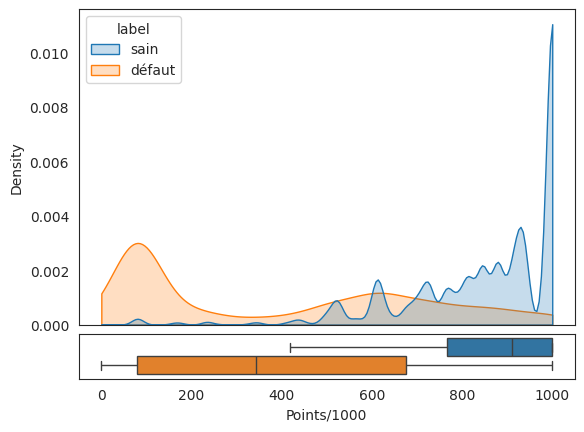

In [120]:
importlib.reload(functions)
functions.plot_kde_and_boxplot(score, cible)

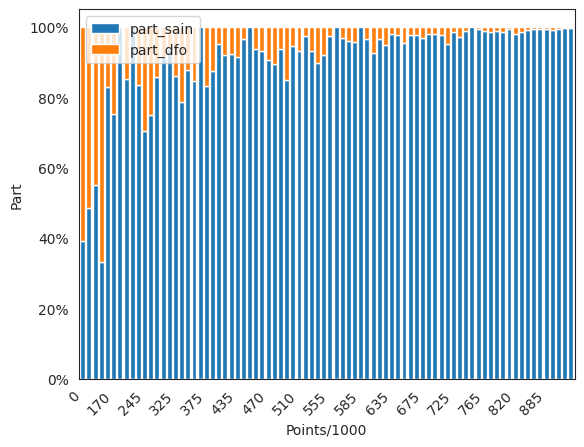

In [121]:
importlib.reload(functions)
functions.plot_bar_stacked(score, cible)

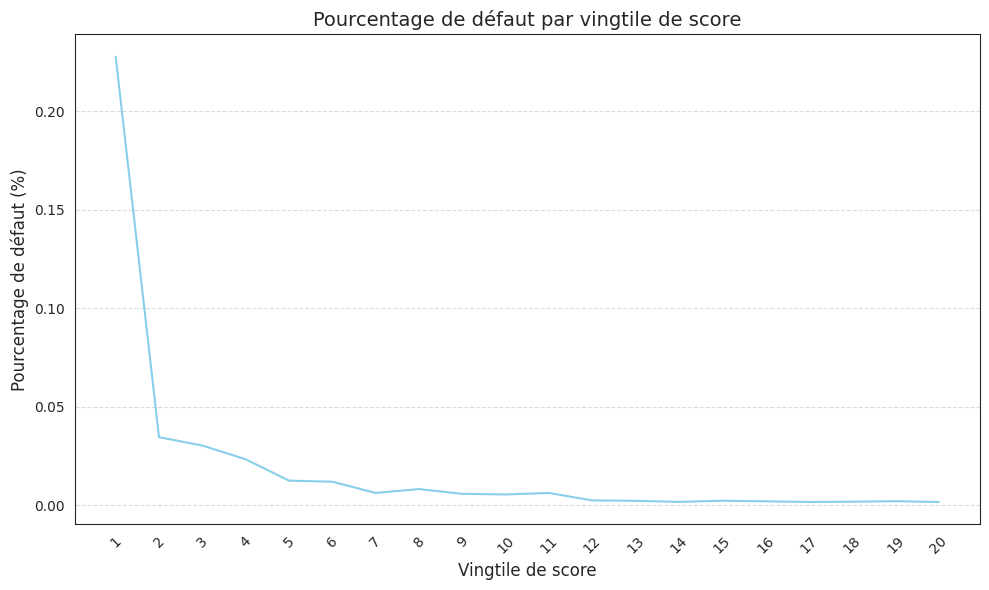

In [122]:
temp_df = score[["score",cible]].copy()

# Créer les vingtiles
# temp_df['ventile'] = pd.qcut(temp_df['score'], q=100, labels=False,duplicates='drop') +1
# temp_df['ventile'] = pd.cut(temp_df['score'], bins=20, labels=False) + 1

# Classer les scores pour leur attribuer des rangs uniques
temp_df['ranked_score'] = temp_df['score'].rank(method='first')

# Diviser les rangs en vingtiles
temp_df['ventile'] = pd.qcut(temp_df['ranked_score'], q=20, labels=False) + 1

# Calculer le pourcentage de défaut par vingtile
ventile_stats = temp_df.groupby('ventile')[cible].mean()# Pourcentage de défaut
ventile_stats.index = ventile_stats.index.astype(str)  # Conversion pour une meilleure lisibilité

# Tracer le graphique (Bar Chart pour une meilleure représentation des proportions)
plt.figure(figsize=(10, 6))
plt.plot(ventile_stats.index, ventile_stats, color='skyblue')  # Barres pour visualiser les pourcentages
plt.title("Pourcentage de défaut par vingtile de score", fontsize=14)
plt.xlabel("Vingtile de score", fontsize=12)
plt.ylabel("Pourcentage de défaut (%)", fontsize=12)
plt.xticks(rotation=45)  # Inclinaison des labels des x pour plus de lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### I.2.1. Combinaison de 6 variables

In [88]:
X_train_reg.columns

Index(['CRTOC_IND_0015_dis', 'CRTOC_IND_0164_dis',
       'CRTOC_AG_NBJCRE_2T_IND_0009_dis', 'ratio_cred_ma_dis',
       'CRTOC_AG_MVTAFF_2T_IND_0010_dis', 'CRTOC_MOY_MVTAFF_IND_0010_dis',
       'CODETAJUR_I_dis', 'SECTNAF', 'DDefaut_NDB', 'datdelhis', 'CODNAF2'],
      dtype='object')

In [101]:
importlib.reload(functions)
nb_var=6
combi_var=functions.combinaisons(selected_vars,nb_var)
results = []
model_summaries = {}  # To store model summaries for each iteration

for cat_vars in tqdm(combi_var):
    gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, \
    flag_VIF, flag_OR,model_train, modalites_reference = functions.logit_reg(list(cat_vars), cible, y_train,X_train_reg,y_test, X_test_reg,y_oot, X_oot_reg)
    # Stocker les résultats
    results.append({
        "Nb de variables": nb_var,
        "Variables": list(cat_vars).copy(),
        "Gini_train": gini_index_train,
        "Gini_test": gini_index_test,
        "Gini_oot": gini_index_oot,
        "AUC-PR_train": auc_pr_train,
        "AUC-PR_test": auc_pr_test,
        "AUC-PR_oot": auc_pr_oot,
        "flag_VIF": flag_VIF,
        "flag_significativite": flag_significativite,
        "flag_OR": flag_OR,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

100%|██████████| 28/28 [03:35<00:00,  7.71s/it]


In [102]:
results_df= pd.DataFrame(results)
results_df

,Nb de variables,Variables,Gini_train,Gini_test,Gini_oot,AUC-PR_train,AUC-PR_test,AUC-PR_oot,flag_VIF,flag_significativite,flag_OR
0,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.787499,0.790861,0.786295,0.329914,0.339082,0.313316,1,0,0
1,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.776400,0.780448,0.776176,0.348306,0.341077,0.316326,1,0,0
2,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.774036,0.777497,0.772287,0.386063,0.382080,0.357817,1,0,0
3,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.788118,0.790957,0.787730,0.344163,0.319777,0.299101,1,0,0
4,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.785967,0.788666,0.784639,0.388888,0.328608,0.307999,1,0,0
5,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.767470,0.769838,0.765946,0.343172,0.342016,0.310315,1,0,0
6,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.783512,0.790026,0.784382,0.340976,0.346104,0.315517,1,1,1
7,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.780445,0.787492,0.780605,0.401333,0.397103,0.379693,1,0,0
8,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.771279,0.774341,0.772048,0.338297,0.331456,0.306389,1,0,0
9,6,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.781962,0.786314,0.783349,0.331992,0.329654,0.308004,1,0,0


In [103]:
vars_selected2 = results_df["Variables"].iloc[6]
gini_index_train, auc_pr_train, gini_index_test, auc_pr_test, gini_index_oot, auc_pr_oot, flag_significativite, flag_VIF, flag_OR, model2, modalites_reference =functions.logit_reg(vars_selected2, cible, y_train, X_train_reg)

In [104]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396399
Method:                           MLE   Df Model:                           11
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                  0.3390
Time:                        23:38:38   Log-Likelihood:                -25306.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.2380      0.040   -155.545      0.000      -6.317      -6.159
CRTOC_IND_0015_dis_(2.0, 8.0]                           1.0031      0.064     15.599      0.000       0.877       1.129
CRTOC_IND_0015_dis_(24.0, inf]                          2.7611      0.036     75.828      0.000       2.690       2.832
CRTOC_IND_0015_dis_(8.0, 24.0]                          1.3912      0.053     26.176      0.000       1.287       1.495
CRTOC_IND_0164_dis_(-inf, 27800.0]                      1.3743      0.045     30.332      0.000       1.286       1.463
CRTOC_IND_0164_dis_(27800.0, 160100.0]                  0.7883      0.050     15.783      0.000       0.690       0.886
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]           0.5916      0.034     17.248      0.000       0.524       0.659
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]         0.4533      0.041     11.172      0.000       0.374       0.533
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 381432.0]     0.3027      0.044      6.908      0.000       0.217       0.389
CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]               0.9564      0.042     22.716      0.000       0.874       1.039
CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 83571.0]            0.1098      0.053      2.071      0.038       0.006       0.214
CODETAJUR_I_dis_[1,5]                                   0.4885      0.046     10.671      0.000       0.399       0.578
=======================================================================================================================
"""

In [105]:
coefficients = pd.Series(model2.params)

for modalite in modalites_reference:
    if modalite not in coefficients.index:
        coefficients[modalite] = 0

coefficients

const                                                 -6.237991
CRTOC_IND_0015_dis_(2.0, 8.0]                          1.003097
CRTOC_IND_0015_dis_(24.0, inf]                         2.761127
CRTOC_IND_0015_dis_(8.0, 24.0]                         1.391152
CRTOC_IND_0164_dis_(-inf, 27800.0]                     1.374333
CRTOC_IND_0164_dis_(27800.0, 160100.0]                 0.788282
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]          0.591592
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]        0.453306
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 381432.0]    0.302708
CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]              0.956370
CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 83571.0]           0.109799
CODETAJUR_I_dis_[1,5]                                  0.488457
CRTOC_IND_0015_dis_(-inf, 2.0]                         0.000000
CRTOC_IND_0164_dis_(160100.0, inf]                     0.000000
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]           0.000000
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.

In [106]:
importlib.reload(functions)
SC_df = functions.compute_score(vars_selected2,coefficients,X_train_reg,cible)
SC_df

,Variables,Variable_Modality,Modalities_merge,coef,alpha_j,"SC(j, i)",CTR,p_k,tx_defaut,relative_gap,m,n,SC_j,q_j
16,CODETAJUR_I_dis,"[6,3,9,2,8]","CODETAJUR_I_dis_[6,3,9,2,8]",0.000000,0.488457,73.727284,0.048846,0.942408,0.018823,0.425489,2,6,69.481202,0.056404
15,CODETAJUR_I_dis,"[1,5]","CODETAJUR_I_dis_[1,5]",0.488457,0.488457,0.000000,0.048846,0.057592,0.032764,0.000000,2,6,69.481202,0.056404
11,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(381432.0, inf]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(381432.0, inf]",0.000000,0.453306,68.421641,0.045331,0.599996,0.007766,0.871627,3,6,45.598992,0.094775
10,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(92950.0, 381432.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 3814...",0.302708,0.453306,22.731190,0.045331,0.200002,0.014341,0.762927,3,6,45.598992,0.094775
9,CRTOC_AG_MVTAFF_2T_IND_0010_dis,"(-inf, 92950.0]","CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]",0.453306,0.453306,0.000000,0.045331,0.200002,0.060492,0.000000,3,6,45.598992,0.094775
8,CRTOC_AG_NBJCRE_2T_IND_0009_dis,"(176.0, inf]","CRTOC_AG_NBJCRE_2T_IND_0009_dis_(176.0, inf]",0.000000,0.591592,89.294409,0.059159,0.794534,0.007112,0.895440,2,6,70.947440,0.118476
7,CRTOC_AG_NBJCRE_2T_IND_0009_dis,"(-inf, 176.0]","CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]",0.591592,0.591592,0.000000,0.059159,0.205466,0.068018,0.000000,2,6,70.947440,0.118476
3,CRTOC_IND_0015_dis,"(-inf, 2.0]","CRTOC_IND_0015_dis_(-inf, 2.0]",0.000000,2.761127,416.762249,0.276113,0.925746,0.008208,0.979179,4,6,397.540932,0.245068
0,CRTOC_IND_0015_dis,"(2.0, 8.0]","CRTOC_IND_0015_dis_(2.0, 8.0]",1.003097,2.761127,265.355660,0.276113,0.025105,0.032657,0.917155,4,6,397.540932,0.245068
2,CRTOC_IND_0015_dis,"(8.0, 24.0]","CRTOC_IND_0015_dis_(8.0, 24.0]",1.391152,2.761127,206.782995,0.276113,0.024485,0.060684,0.846054,4,6,397.540932,0.245068


In [107]:
importlib.reload(functions)
score = functions.calculate_individual_scores(SC_df, X_train_reg[vars_selected2+[cible]])

396411it [00:14, 27541.82it/s]


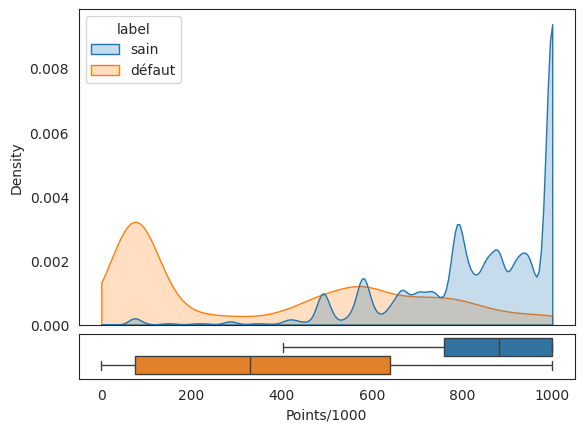

In [108]:
importlib.reload(functions)
functions.plot_kde_and_boxplot(score, cible)

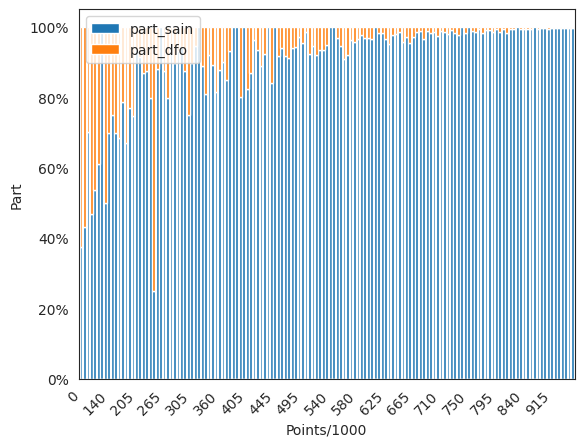

In [109]:
importlib.reload(functions)
functions.plot_bar_stacked(score, cible)

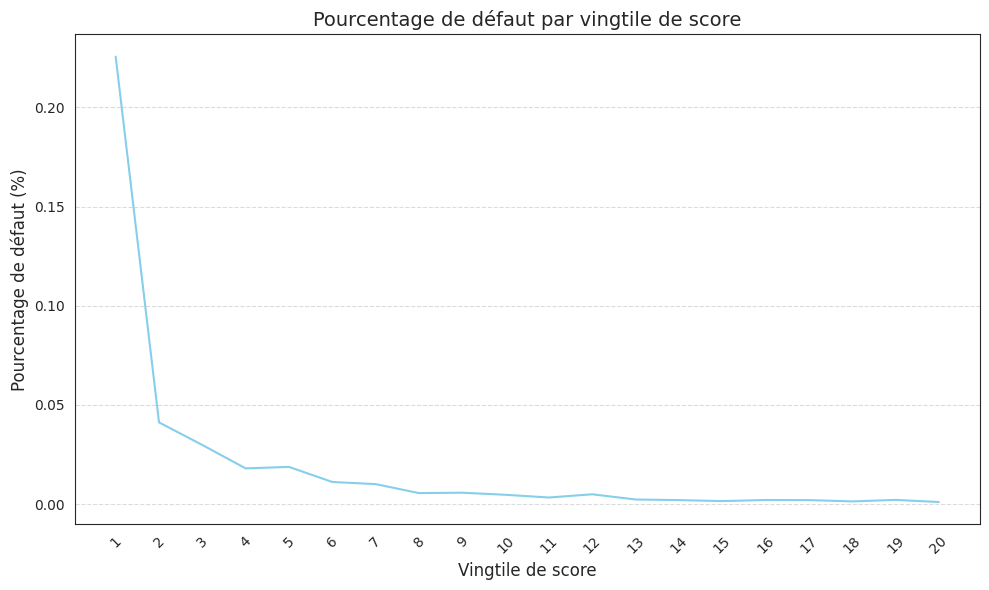

In [110]:
temp_df = score[["score",cible]].copy()

# Créer les vingtiles
# temp_df['ventile'] = pd.qcut(temp_df['score'], q=100, labels=False,duplicates='drop') +1
# temp_df['ventile'] = pd.cut(temp_df['score'], bins=20, labels=False) + 1

# Classer les scores pour leur attribuer des rangs uniques
temp_df['ranked_score'] = temp_df['score'].rank(method='first')

# Diviser les rangs en vingtiles
temp_df['ventile'] = pd.qcut(temp_df['ranked_score'], q=20, labels=False) + 1

# Calculer le pourcentage de défaut par vingtile
ventile_stats = temp_df.groupby('ventile')[cible].mean()# Pourcentage de défaut
ventile_stats.index = ventile_stats.index.astype(str)  # Conversion pour une meilleure lisibilité

# Tracer le graphique (Bar Chart pour une meilleure représentation des proportions)
plt.figure(figsize=(10, 6))
plt.plot(ventile_stats.index, ventile_stats, color='skyblue')  # Barres pour visualiser les pourcentages
plt.title("Pourcentage de défaut par vingtile de score", fontsize=14)
plt.xlabel("Vingtile de score", fontsize=12)
plt.ylabel("Pourcentage de défaut (%)", fontsize=12)
plt.xticks(rotation=45)  # Inclinaison des labels des x pour plus de lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### I.2.2. Combinaison de 7 variables

In [89]:
importlib.reload(functions)
combi_var=functions.combinaisons(selected_vars,7)
results = []
model_summaries = {}  # To store model summaries for each iteration

for cat_vars in tqdm(combi_var):
    gini_index_train, auc_pr_train,gini_index_test,auc_pr_test, flag_significativite, flag_VIF, flag_OR,model_train, modalites_reference = functions.logit_reg(list(cat_vars), cible, y_train,X_train_reg,y_test, X_test_reg)
    # Stocker les résultats
    results.append({
        "Nb de variables": len(cat_vars),
        "Variables": list(cat_vars).copy(),
        "Gini_train": gini_index_train,
        "Gini_test": gini_index_test,
        "AUC-PR_train": auc_pr_train,
        "AUC-PR_test": auc_pr_test,
        "flag_VIF": flag_VIF,
        "flag_significativite": flag_significativite,
        "flag_OR": flag_OR,
    })

    # Stocker le résumé du modèle
    model_summaries[f"Model_{i+1}"] = model_train.summary()

100%|██████████| 8/8 [01:12<00:00,  9.10s/it]


In [90]:
results_df= pd.DataFrame(results)
results_df

,Nb de variables,Variables,Gini_train,Gini_test,AUC-PR_train,AUC-PR_test,flag_VIF,flag_significativite,flag_OR
0,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.789753,0.793879,0.329883,0.331372,1,0,0
1,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.787646,0.791461,0.327695,0.336121,1,0,0
2,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.776414,0.781166,0.345665,0.339531,1,0,0
3,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.788300,0.791345,0.342834,0.320612,1,0,0
4,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, CRTOC...",0.783362,0.790280,0.338207,0.341985,1,0,0
5,7,"[CRTOC_IND_0015_dis, CRTOC_IND_0164_dis, ratio...",0.785161,0.788360,0.324802,0.329344,1,0,0
6,7,"[CRTOC_IND_0015_dis, CRTOC_AG_NBJCRE_2T_IND_00...",0.772629,0.780618,0.321692,0.327462,1,0,0
7,7,"[CRTOC_IND_0164_dis, CRTOC_AG_NBJCRE_2T_IND_00...",0.764751,0.770667,0.171676,0.184391,1,0,0


En essayant de faire une régression logistique avec 7 variables, aucun modèle ne passent le test de significativité globale du modèle. On peut s'arrêter à une combinaisons de 6 variables.

## I.3 Comparaison des modèles de regression logistique

In [185]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396404
Method:                           MLE   Df Model:                            6
Date:                Wed, 25 Dec 2024   Pseudo R-squ.:                  0.3169
Time:                        14:54:14   Log-Likelihood:                -26154.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -5.7555      0.035   -165.091      0.000      -5.824      -5.687
CRTOC_IND_0015_dis_(2.0, 8.0]                     0.4082      0.062      6.586      0.000       0.287       0.530
CRTOC_IND_0015_dis_(24.0, inf]                    2.9003      0.036     80.538      0.000       2.830       2.971
CRTOC_IND_0015_dis_(8.0, 24.0]                    0.8500      0.051     16.742      0.000       0.750       0.950
CRTOC_IND_0164_dis_(-inf, 27800.0]                1.8708      0.043     43.815      0.000       1.787       1.954
CRTOC_IND_0164_dis_(27800.0, 160100.0]            0.9291      0.049     18.826      0.000       0.832       1.026
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]     0.6458      0.034     19.058      0.000       0.579       0.712
=================================================================================================================
"""

In [124]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396401
Method:                           MLE   Df Model:                            9
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                  0.3307
Time:                        23:52:10   Log-Likelihood:                -25623.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.0370      0.038   -159.741      0.000      -6.111      -5.963
CRTOC_IND_0015_dis_(2.0, 8.0]                           0.7226      0.063     11.492      0.000       0.599       0.846
CRTOC_IND_0015_dis_(24.0, inf]                          2.8355      0.036     78.263      0.000       2.764       2.907
CRTOC_IND_0015_dis_(8.0, 24.0]                          1.1425      0.052     22.090      0.000       1.041       1.244
CRTOC_IND_0164_dis_(-inf, 27800.0]                      1.4977      0.045     33.647      0.000       1.410       1.585
CRTOC_IND_0164_dis_(27800.0, 160100.0]                  0.7768      0.050     15.560      0.000       0.679       0.875
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]           0.5761      0.034     16.774      0.000       0.509       0.643
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]         0.9906      0.033     30.351      0.000       0.927       1.055
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 381432.0]     0.4189      0.040     10.386      0.000       0.340       0.498
CODETAJUR_I_dis_[1,5]                                   0.5140      0.046     11.228      0.000       0.424       0.604
=======================================================================================================================
"""

In [186]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               396411
Model:                          Logit   Df Residuals:                   396399
Method:                           MLE   Df Model:                           11
Date:                Wed, 25 Dec 2024   Pseudo R-squ.:                  0.3390
Time:                        14:54:17   Log-Likelihood:                -25306.
converged:                       True   LL-Null:                       -38286.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -6.2380      0.040   -155.545      0.000      -6.317      -6.159
CRTOC_IND_0015_dis_(2.0, 8.0]                           1.0031      0.064     15.599      0.000       0.877       1.129
CRTOC_IND_0015_dis_(24.0, inf]                          2.7611      0.036     75.828      0.000       2.690       2.832
CRTOC_IND_0015_dis_(8.0, 24.0]                          1.3912      0.053     26.176      0.000       1.287       1.495
CRTOC_IND_0164_dis_(-inf, 27800.0]                      1.3743      0.045     30.332      0.000       1.286       1.463
CRTOC_IND_0164_dis_(27800.0, 160100.0]                  0.7883      0.050     15.783      0.000       0.690       0.886
CRTOC_AG_NBJCRE_2T_IND_0009_dis_(-inf, 176.0]           0.5916      0.034     17.248      0.000       0.524       0.659
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(-inf, 92950.0]         0.4533      0.041     11.172      0.000       0.374       0.533
CRTOC_AG_MVTAFF_2T_IND_0010_dis_(92950.0, 381432.0]     0.3027      0.044      6.908      0.000       0.217       0.389
CRTOC_MOY_MVTAFF_IND_0010_dis_(-inf, 0.0]               0.9564      0.042     22.716      0.000       0.874       1.039
CRTOC_MOY_MVTAFF_IND_0010_dis_(0.0, 83571.0]            0.1098      0.053      2.071      0.038       0.006       0.214
CODETAJUR_I_dis_[1,5]                                   0.4885      0.046     10.671      0.000       0.399       0.578
=======================================================================================================================
"""